In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from random import shuffle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [3]:
def plotmyimage(img,title=''):
    #This function is used during the debug phase. 
    #This just plots the image 
    plt.imshow(img,cmap='gray') # draws in grayscale if it is M x N x 1, draws in color if RGB
    plt.title(title)
    plt.show()


In [4]:
#read the images
cars=glob.glob('vehicles/vehicles/*/*.png')
notcars=glob.glob('non-vehicles/non-vehicles/*/*.png')
shuffle(cars)
shuffle(notcars)

Number of car images found are     :8792
Number of non-car images found are :8968
Size of a sample image is          :(64, 64, 3)


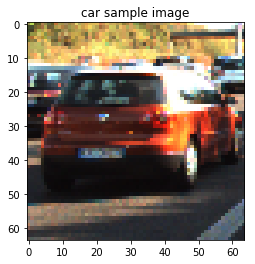

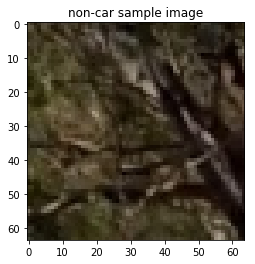

In [5]:
#Dataset exploration and Visualization
print('Number of car images found are     :' + str(len(cars)))
print('Number of non-car images found are :' + str(len(notcars)))
print('Size of a sample image is          :' + str(mpimg.imread(cars[0]).shape))

plotmyimage(mpimg.imread(cars[random.randint(0, len(cars)-1)]),'car sample image')
plotmyimage(mpimg.imread(notcars[random.randint(0,len(notcars)-1)]),'non-car sample image')


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


The function get_hog_features() resulted in features array with the size: (7, 7, 2, 2, 9)


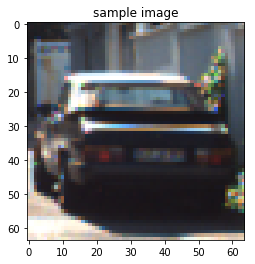

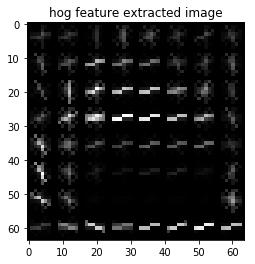

In [6]:


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
#working with HOG features
orient = 9
pix_per_cell = 8
cell_per_block = 2
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 0 # Can be 0, 1, 2, or "ALL"



img=mpimg.imread(cars[random.randint(0, len(cars)-1)])

gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)

print('The function get_hog_features() resulted in features array with the size: ' +str(features.shape))

plotmyimage(img,'sample image')

plotmyimage(hog_image,'hog feature extracted image')




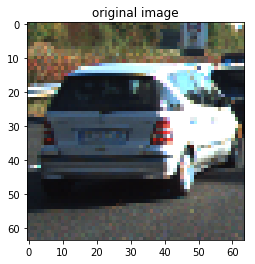

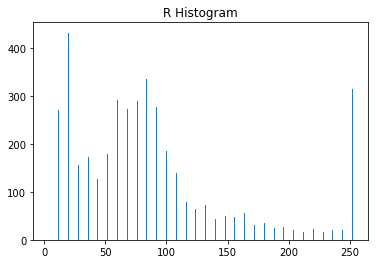

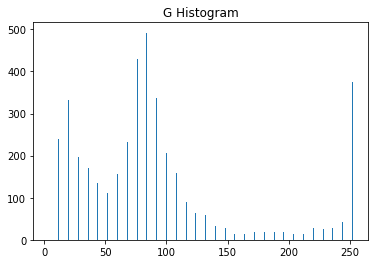

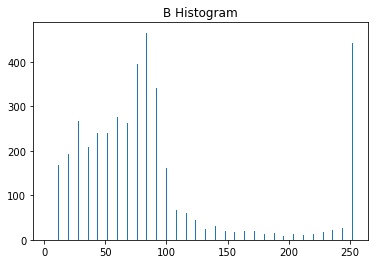

In [7]:

# Define a function to compute color histogram features  
def color_hist(image, nbins=32, bins_range=(0, 256),vis=False):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)

    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)

    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)

    # Generating bin centers
    bin_edges=rhist[1]

    bin_centers = bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if vis==True:
        return rhist, ghist, bhist, bin_centers
    else:
        return hist_features

#reading a random image
img=mpimg.imread(cars[random.randint(0, len(cars)-1)])
#plotting the sample image
plotmyimage(img,'original image')
#scaling up the pixel values for png images so that the values are correctly represented
img=img*256
#calling function for color histofram
rh, gh, bh, bincen = color_hist(img, vis=True)
plt.bar(bincen, rh[0])
#plt.xlim(0, 256)
plt.title('R Histogram')
plt.show()

plt.bar(bincen, gh[0])
#plt.xlim(0, 256)
plt.title('G Histogram')
plt.show()

plt.bar(bincen, bh[0])
#plt.xlim(0, 256)
plt.title('B Histogram')
plt.show()

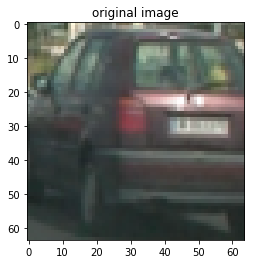

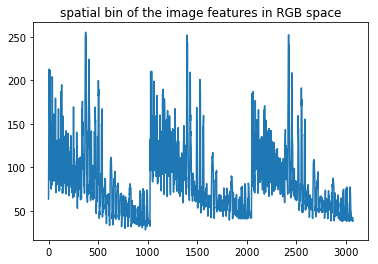

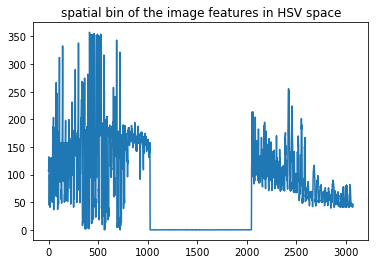

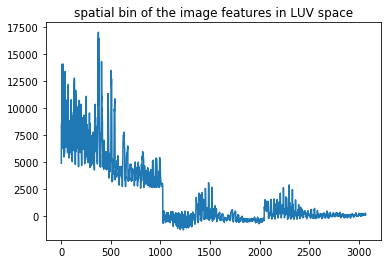

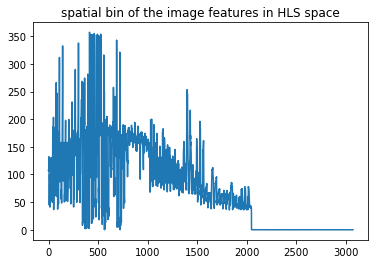

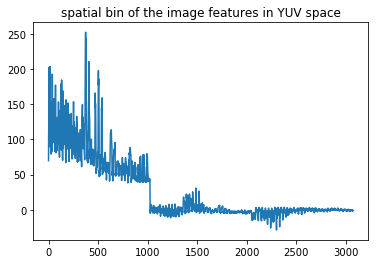

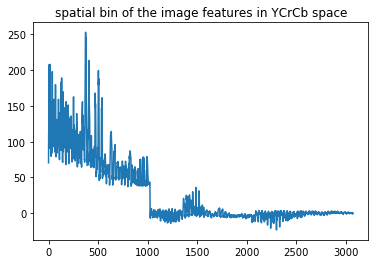

In [8]:

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(feature_image[:,:,0], size).ravel()
    color2 = cv2.resize(feature_image[:,:,1], size).ravel()
    color3 = cv2.resize(feature_image[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


img=mpimg.imread(cars[random.randint(0, len(cars)-1)])
#plotting the sample image
plotmyimage(img,'original image')
#scaling up the pixel values so that the values are correctly represented
img=img*256
plt.show()

bin_f=bin_spatial(img)
plt.plot(bin_f)
plt.title('spatial bin of the image features in RGB space')
plt.show()

bin_f=bin_spatial(img,color_space='HSV')
plt.plot(bin_f)
plt.title('spatial bin of the image features in HSV space')
plt.show()

bin_f=bin_spatial(img,color_space='LUV')
plt.plot(bin_f)
plt.title('spatial bin of the image features in LUV space')
plt.show()

bin_f=bin_spatial(img,color_space='HLS')
plt.plot(bin_f)
plt.title('spatial bin of the image features in HLS space')
plt.show()

bin_f=bin_spatial(img,color_space='YUV')
plt.plot(bin_f)
plt.title('spatial bin of the image features in YUV space')
plt.show()

bin_f=bin_spatial(img,color_space='YCrCb')
plt.plot(bin_f)
plt.title('spatial bin of the image features in YCrCb space')
plt.show()


In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [10]:
#working with HOG features
orient = 9
pix_per_cell = 8
cell_per_block = 2
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

cars_features=extract_features(cars,color_space=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                               hog_channel=hog_channel)
notcars_features=extract_features(notcars,color_space=colorspace,orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                  hog_channel=hog_channel)
print('Total number of features of cars are     : ' +str(np.array(cars_features).shape))
print('Total number of features of non-cars are : ' +str(np.array(notcars_features).shape))

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Total number of features of cars are     : (8792, 8460)
Total number of features of non-cars are : (8968, 8460)


In [11]:
X = np.vstack((cars_features, notcars_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(cars_features)), np.zeros(len(notcars_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [12]:
import time
# Use a linear SVC
svc = LinearSVC(loss='hinge')
t=time.time()
# Check the training time for the SVC
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


7.55 Seconds to train SVC...


In [13]:
score=svc.score(X_test,y_test)
print('The test accuracy turned out to be '+str(round(score*100,1))+'%')

The test accuracy turned out to be 99.2%


In [14]:
print('Total prediction errors with the test set are : ' + str(sum((svc.predict(X_train)-y_train))))

Total prediction errors with the test set are : 0.0


In [15]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    

In [16]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
# Define a single function that can extract features using hog sub-sampling and make predictions

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    boxes=[]
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = np.copy(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = np.hstack((hog_feat1))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return draw_img, boxes

test_images/test5.jpg


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


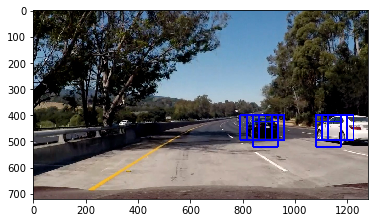

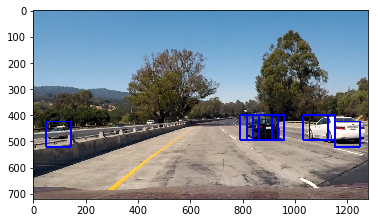

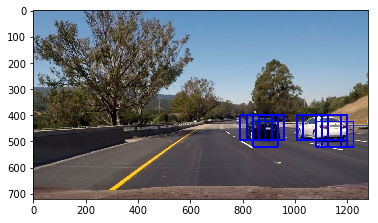

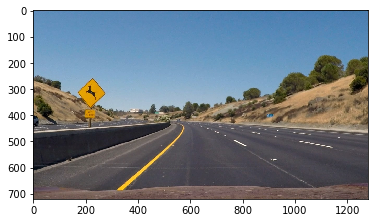

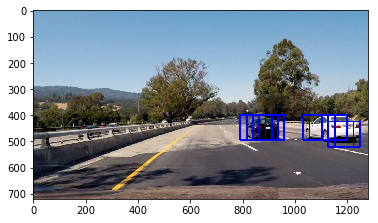

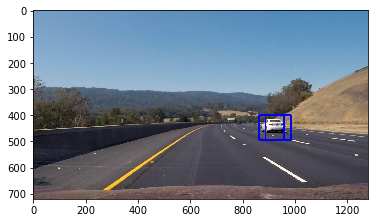

In [17]:
images=glob.glob('test_images/*.jpg')
print(images[0])
#file=images[0]
for file in images:
    image1=(mpimg.imread(file))
    image=np.copy(image1)
    #image = image.astype(np.float32)/255
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
    #                xy_window=(128, 128), xy_overlap=(0.85, 0.85))


    #window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
    #plotmyimage(window_img,'search grid on a sample image')

    colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    ystart = 400
    ystop = 656
    scale = 1.5
    spatial_size=(32,32)
    hist_bins=32
    window_img,hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)                   
    plotmyimage(window_img)

    


In [18]:
np.max(window_img)

255

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print(box.shape)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [20]:

#for file in images:



file=images[0]
image1=(mpimg.imread(file))
image=np.copy(image1)

#image = image.astype(np.float32)/255



bbox_list = []
orient=10
pix_per_cell=8
cell_per_block=2
spatial_size=(32, 32)
hist_bins=64

ystart = 400
ystop = 656
scale = 1.0

_,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                orient=9, pix_per_cell=8, cell_per_block=2,
                                spatial_size=(32,32), hist_bins=32)
bbox_list.append(boxes)

ystart = 350
ystop = 706
scale = 2.0

_,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                orient=9, pix_per_cell=8, cell_per_block=2,
                                spatial_size=(32,32), hist_bins=32)
bbox_list.append(boxes)

ystart = 400
ystop = 656
scale = 1.5

_,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                orient=9, pix_per_cell=8, cell_per_block=2,
                                spatial_size=(32,32), hist_bins=32)
bbox_list.append(boxes)

ystart = 300
ystop = 656
scale = 2.0

_,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                orient=9, pix_per_cell=8, cell_per_block=2,
                                spatial_size=(32,32), hist_bins=32)
bbox_list.append(boxes)

ystart = 400
ystop = 720
scale = 2.5

_,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                orient=9, pix_per_cell=8, cell_per_block=2,
                                spatial_size=(32,32), hist_bins=32)
bbox_list.append(boxes)

bbox_list = [item for sublist in bbox_list for item in sublist] 





/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [ ]:


heat = np.zeros_like(image[:,:,0]).astype(np.float)
#print(heat)
heat = add_heat(heat, bbox_list)
heat = apply_threshold(heat, 2)  

heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [ ]:
plotmyimage(draw_img)

In [ ]:
plotmyimage(heatmap)

In [ ]:
def process_frame(image):
    
    bbox_list = []
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64

    ystart = 400
    ystop = 656
    scale = 1.0

    _,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                    orient=9, pix_per_cell=8, cell_per_block=2,
                                    spatial_size=(32,32), hist_bins=32)
    bbox_list.append(boxes)

    ystart = 350
    ystop = 706
    scale = 2.0

    _,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                    orient=9, pix_per_cell=8, cell_per_block=2,
                                    spatial_size=(32,32), hist_bins=32)
    bbox_list.append(boxes)

    ystart = 400
    ystop = 656
    scale = 1.5

    _,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                    orient=9, pix_per_cell=8, cell_per_block=2,
                                    spatial_size=(32,32), hist_bins=32)
    bbox_list.append(boxes)

    ystart = 300
    ystop = 656
    scale = 2.0

    _,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                    orient=9, pix_per_cell=8, cell_per_block=2,
                                    spatial_size=(32,32), hist_bins=32)
    bbox_list.append(boxes)

    ystart = 400
    ystop = 720
    scale = 2.5

    _,boxes=find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                    orient=9, pix_per_cell=8, cell_per_block=2,
                                    spatial_size=(32,32), hist_bins=32)
    bbox_list.append(boxes)

    bbox_list = [item for sublist in bbox_list for item in sublist] 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    #print(heat)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [59:38<00:02,  2.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 3min 14s, sys: 17.6 s, total: 1h 3min 32s
Wall time: 59min 39s
